# Formeln vom Manual

In [10]:
import numpy as np
import uncertainties as u
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties.umath import __all__
from uncertainties.umath import *
import uncertainties.unumpy as unp
import scipy.constants
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas # pip install Jinja2
import pint # pip install pint OR conda install pint
units = pint.UnitRegistry()
units.default_format = '~'
umean = u.wrap(np.mean)
ustd = u.wrap(np.std)
usin = u.wrap(np.sin)
no_unit = (units.m/units.m)
usquare = u.wrap(np.square)
import warnings
warnings.simplefilter("ignore")
cm = 1/2.54

def strip_units(np_arr):
    return np.array([(a.to_base_units().magnitude if type(a)!=float else a) for a in np_arr])

def extr_values(np_arr):
    return unp.nominal_values(np_arr)

def extr_sig(np_arr):
    return unp.std_devs(np_arr)

def errorbar_plot_with_linregress(X, Y, SIG_Y, errbarlabel='errbarlabel', xlabel='xlabel', ylabel='ylabel', errbarcolor='blue', linfitlabel='linfitlabel', nolinregress=False):
    result = scipy.stats.linregress(X, Y)
    #slope, intercept, rvalue, pvalue, sevalue, inteerr
    print("slope: ", result.slope)
    print("slope_err:", result.stderr)
    print("intercept: ", result.intercept)
    x_axis_spaced = np.linspace(np.min(X), np.max(X), 10)
    fig, ax = plt.subplots(1,1,figsize=(8*cm, 8*cm))
    #ax.plot(x,y,linestyle='-', color='red')
    if not nolinregress:
        ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'r--', label=linfitlabel)
    ax.errorbar(X, Y, yerr=SIG_Y, linestyle='', color=errbarcolor, capsize=3, label=errbarlabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_xlim([-1,1])
    #ax.set_ylim([-4,4])
    ax.legend(loc='upper left')
    plt.show()
    if not nolinregress:
        return u.ufloat(result.slope, result.stderr), u.ufloat(result.intercept, result.intercept_stderr) # (slope+=unc), (intercept+=unc)

# Formel (2)
# n'2(nu) = 1 + A/(nu0dash^2-nu^2)
# nu0dash, A sind Materialkonstanten
def n_squared_of_nu(nu, nu0dash, A):
    n_sq = 1 + A/(u.wrap(np.square)(nu0dash)-u.wrap(np.square)(nu))
    return n_sq

def n_squared_of_nu_squared(nu_squared, nu0dash, A):
    n_sq = 1 + A/(nu0dash**2-nu_squared)
    return n_sq

# Formel (2) und die Wurzel gezogen
def n_of_nu(nu, nu0dash, A):
    #n = u.wrap(np.sqrt)(n_squared_of_nu(nu, nu0dash,A))
    n = np.array([u.wrap(np.sqrt)(n_squared_of_nu(nu_i, nu0dash, A)) for nu_i in nu])
    return n

def n_of_phi_delta0(phi, delta0):
    left = usin((delta0 + phi)/2)
    right = usin(phi/2)
    eta = left/right
    return eta

# nu0dash, A sind Materialkonstanten
def f_of_nu_squared(nu_squared, nu0dash, A):
    denom = (n_squared_of_nu_squared(nu_squared, nu0dash, A)-1.0)
    f = 1/ np.array(strip_units([(d if np.abs(d) >= 0.000000001 else 0.000000001) for d in denom])) * no_unit
    return f

# used if n_squared is already known
def f_of_n_squared(n_squared):
    f = 1/(n_squared-1)
    return f

# calculate frequency from wavelength
def nu_of_lambda(lambda_, c0=scipy.constants.c*units.meter/units.s):
    return c0/lambda_

def delta0_of_A1_A2(A1, A2):
    return (A1 - A2)/2

# Testchange

# First Task: Determine $\varphi$
Measure both positions where the reflections of the slit image are observed: $A_{1}$, $A_{2}$. Then $\beta = A_{1} - A_{2}$. Make sure the signs are correct (can we take the absolute value?). Do this three times, so we get three $\beta$ values. Take the mean of $\beta$. Then $\varphi = \pi - \beta$.

In [16]:
A1_deg, A2_deg, A1_deg_minutes, A2_deg_minutes = np.genfromtxt(os.path.join(os.getcwd(), "task1_measure_phi_data.csv"), delimiter=',', skip_header=1, unpack=True)
##A1_meas_deg = A1_deg - 360 + (1.0/60.0)*A1_deg_minutes
A1_meas_deg = A1_deg + (1.0/60.0)*A1_deg_minutes
A2_meas_deg = A2_deg + (1.0/60.0)*A2_deg_minutes
A1_meas = np.radians(A1_meas_deg)
A2_meas = np.radians(A2_meas_deg)

A_meas_uncertainty_guess_deg = (1.0/60.0)*(2) # = (2)degmin' is unc of device but its difficult to read off minutes so we set 2' A meas uncertainty in degrees
A_meas_uncertainty_guess = np.radians(A_meas_uncertainty_guess_deg)
A_unit = units.rad
A1s = np.array([u.ufloat(a1, A_meas_uncertainty_guess) for a1 in A1_meas]) *A_unit
A2s = np.array([u.ufloat(a2, A_meas_uncertainty_guess) for a2 in A2_meas]) *A_unit

Betas =  (A1s - A2s)
Betas_Std = np.std(extr_values(Betas))

Beta = umean(Betas)

# PRINT AND GENERATE LATEX
DF_TABLE_1 = pandas.DataFrame({"A1 [%s]"%(units.rad): A1s, "A2 []": A2s, r'$\beta$': Betas})
print("Table of Data:")
print(DF_TABLE_1, '\n')
print("Table latex:")
print(DF_TABLE_1.style.to_latex(column_format='|l|l|l|l|'), '\n')
print("Mean(beta)+=prop_unc_a: ", Beta, '\n')
print("Mean(beta)+=Std(betas):", u.ufloat(Beta.nominal_value,Betas_Std)*A_unit)

Beta_Result = Beta
if (Beta.std_dev < Betas_Std):
    Beta_Result = u.ufloat(Beta.nominal_value, Betas_Std)*A_unit
    print("Standard deviation of the betas was higher so this was taken instead of the propagation of the errors of measurement of A.")
else:
    Beta_Result = Beta
    print("Standard deviation of the betas was lower than the propagation of the errors of measurement of A. So the propagated error was taken.")
Beta_Result_Deg = np.abs(Beta_Result / (2*np.pi) * 360 / A_unit)

print("Beta End Result (rad, deg): (", Beta_Result, ",", Beta_Result_Deg, ")")

##Phi_Result = np.abs((scipy.constants.pi*A_unit - Beta) - 2*scipy.constants.pi*A_unit)
Phi_Result = np.abs(scipy.constants.pi*A_unit - Beta)
Phi_Result_Deg = Phi_Result / (2*np.pi) * 360 / A_unit
print("Phi end result (rad, deg): (", Phi_Result, ",", Phi_Result_Deg, ")")

Table of Data:
          A1 [rad]            A2 []          $\beta$
0  5.5952+/-0.0006  1.4003+/-0.0006  4.1949+/-0.0008
1  5.6159+/-0.0006  1.4268+/-0.0006  4.1891+/-0.0008
2  5.7299+/-0.0006  1.5405+/-0.0006  4.1894+/-0.0008 

Table latex:
\begin{tabular}{|l|l|l|l|}
 & A1 [rad] & A2 [] & $\beta$ \\
0 & 5.5952+/-0.0006 & 1.4003+/-0.0006 & 4.1949+/-0.0008 \\
1 & 5.6159+/-0.0006 & 1.4268+/-0.0006 & 4.1891+/-0.0008 \\
2 & 5.7299+/-0.0006 & 1.5405+/-0.0006 & 4.1894+/-0.0008 \\
\end{tabular}
 

Mean(beta)+=prop_unc_a:  4.1911+/-0.0005 rad 

Mean(beta)+=Std(betas): 4.1911+/-0.0027 rad
Standard deviation of the betas was higher so this was taken instead of the propagation of the errors of measurement of A.
Beta End Result (rad, deg): ( 4.1911+/-0.0027 rad , 240.13+/-0.15 )
Phi end result (rad, deg): ( 1.0495+/-0.0005 rad , 60.133+/-0.027 )


# Second Task{Determine $\eta$ and the dispersion curve.}
For various wavelengths of the incident light, we are going to measure for which positions $A_{1}, A_{2}$ the deflection angle $\delta$ approaches its minimum $\delta^*$. For known $\boldsymbol{\lambda's}$ we will $\overline{measure}$ and $\underline{calculate}$ the ($\boldsymbol{\lambda}$, $\underline{\nu^2} = (\frac{c_{0}}{\lambda})^2$, $\overline{A_{1}}$, $\overline{A_{2}}$, $\underline{\delta^*} = \frac{A_{1}-A_{2}}{2}$, $\underline{\eta}$, $\underline{f(\nu^2)} =\frac{1}{\eta^2(v)-1}$) tuples.

SEE FUNCTIONS DEFINED IN THE FIRST BLOCK

slope:  -1.3348864636941402e-31
slope_err: 5.968883442952754e-33
intercept:  0.6537652683362825


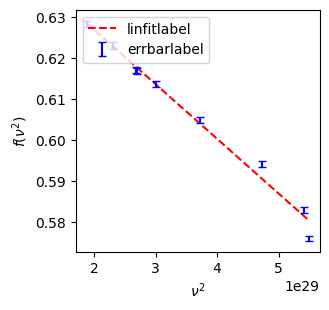

Magnitude,[47.37499999999998+/-0.04714045207910317 47.78333333333333+/-0.04714045207910317 48.258333333333326+/-0.04714045207910317 48.27916666666667+/-0.04714045207910317 48.53333333333331+/-0.04714045207910317 49.24166666666664+/-0.04714045207910317 50.16666666666668+/-0.04714045207910317 51.150000000000006+/-0.04714045207910317 51.791666666666686+/-0.04714045207910317]
Units,


In [17]:
# SET UNCERTAINTIES
A_meas_uncertainty_guess_deg = (1.0/60.0)*(4) # = (2)degmin' is unc of device but its difficult to read off minutes so we set 2' A meas uncertainty in degrees
A_meas_uncertainty_guess2 = np.radians(A_meas_uncertainty_guess_deg)
A_meas_uncertainty_guess = A_meas_uncertainty_guess2 # already defined above
Lambda_uncertainty_guess = 0.05 # nanometer

# SET UNITS
A_unit = units.rad
Lambda_unit = units.nanometer

# IMPORT DATA
Lambda_meas, A1_meas_deg, A2_meas_deg, A1_meas_degmin, A2_meas_degmin, Lambda_labels = np.genfromtxt(os.path.join(os.getcwd(), "task2_measure_lambda_a1_a2.csv"), delimiter=',', skip_header=1, unpack=True)
A1_meas = np.radians(A1_meas_deg + (1.0/60.0)*A1_meas_degmin)
A2_meas = np.radians(A2_meas_deg + (1.0/60.0)*A2_meas_degmin)
A1s = np.array([u.ufloat(a1 + 2*np.pi, A_meas_uncertainty_guess) for a1 in A1_meas]) *A_unit
A2s = np.array([u.ufloat(a2, A_meas_uncertainty_guess) for a2 in A2_meas]) *A_unit
Lambdas = np.array([u.ufloat(l, Lambda_uncertainty_guess) for l in Lambda_meas]) *Lambda_unit

# CALCULATE BELONGING VALUES
Nus = nu_of_lambda(Lambdas).to_base_units().to_compact()
Nu_Squareds = np.square(Nus).to_base_units().to_compact()
Delta0s = delta0_of_A1_A2(A1s, A2s).to_base_units().to_compact()
# Using Eq. 8 to figure out the refractive indexes
Etas = np.array([n_of_phi_delta0(Phi_Result.magnitude, Delta0.magnitude) for Delta0 in Delta0s]) * no_unit
Eta_Squareds = usquare(Etas)
Fs = f_of_n_squared(Eta_Squareds)

slope_withErr, intercept_withErr = errorbar_plot_with_linregress(extr_values(Nu_Squareds), extr_values(Fs), extr_sig(Fs), nolinregress=False, xlabel=r'$\nu^2$', ylabel=r'$f(\nu^2)$')

# CALCULATE MATERIAL CONSTANTS FROM THE CURVE
nu0dash_Squared = intercept_withErr
nu0dash = u.wrap(np.sqrt)(nu0dash_Squared) * (1/units.s)
A_param = (1/slope_withErr) * (1/units.s**2)

Delta0s / (2*scipy.constants.pi) * 360 / units.rad

# Task 3 Calculate f again with EQ 2 and compare

slope:  1.33488646369414e-31
slope_err: 0.0
intercept:  0.0


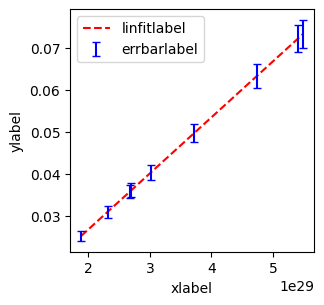

(1.33488646369414e-31+/-0, 0.0+/-0)

In [18]:
# TASK 3 NOW WE USE EQ 2 AND COMPARE
Eta_Squareds__EQ2 = n_squared_of_nu(Nus, nu0dash, A_param).to_base_units().to_compact()
Etas__EQ2 = np.array([u.wrap(np.sqrt)(eta_sq.to_base_units().magnitude) for eta_sq in Eta_Squareds__EQ2]) * no_unit
Fs__EQ2 = f_of_nu_squared(Nu_Squareds, nu0dash, A_param)
slope_withErr__Eq2, intercept_withErr__Eq2 = errorbar_plot_with_linregress(extr_values(Nu_Squareds), extr_values(Fs__EQ2), extr_sig(Fs__EQ2), nolinregress=False)

slope_withErr__Eq2, intercept_withErr__Eq2

In [19]:
# PRINT AND GENERATE LATEX
DF_TABLE_2 = pandas.DataFrame({"Lambdas": Lambdas, "Nus [%s]"%(""): Nus, "NuSquareds []": Nu_Squareds, "A1s": A1s, "A2s": A2s, "delt*s": Delta0s, "n's": Etas, "f's": Fs, "f's by Eq (2):": Fs__EQ2})
print("Table of Data:")
print(DF_TABLE_2, '\n')
print("Table latex:")
print(DF_TABLE_2.style.to_latex(column_format='|l|l|l|l|l|l|l|l|'), '\n')
print("A: ", A_param, '\n')
print("nu_0dash:", nu0dash)

Table of Data:
         Lambdas                   Nus []            NuSquareds []  \
0  690.80+/-0.05  (4.33979+/-0.00031)e+14  (1.88337+/-0.00027)e+29   
1  623.40+/-0.05    (4.8090+/-0.0004)e+14    (2.3126+/-0.0004)e+29   
2  579.10+/-0.05    (5.1769+/-0.0004)e+14    (2.6800+/-0.0005)e+29   
3  577.00+/-0.05    (5.1957+/-0.0005)e+14    (2.6995+/-0.0005)e+29   
4  546.10+/-0.05    (5.4897+/-0.0005)e+14    (3.0137+/-0.0006)e+29   
5  491.60+/-0.05    (6.0983+/-0.0006)e+14    (3.7189+/-0.0008)e+29   
6  435.80+/-0.05    (6.8791+/-0.0008)e+14    (4.7322+/-0.0011)e+29   
7  407.80+/-0.05    (7.3515+/-0.0009)e+14    (5.4044+/-0.0013)e+29   
8  404.70+/-0.05    (7.4078+/-0.0009)e+14    (5.4875+/-0.0014)e+29   

               A1s              A2s           delt*s              n's  \
0  6.3658+/-0.0012  4.7121+/-0.0012  0.8268+/-0.0008  1.6097+/-0.0006   
1  6.3748+/-0.0012  4.7069+/-0.0012  0.8340+/-0.0008  1.6139+/-0.0006   
2  6.3821+/-0.0012  4.6976+/-0.0012  0.8423+/-0.0008  1.6188+/-0.

0.016666666666666666